<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1">Setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1">Imports</a></span></li><li><span><a href="#Cleaning-function" data-toc-modified-id="Cleaning-function-1.2">Cleaning function</a></span></li><li><span><a href="#Visuals-function" data-toc-modified-id="Visuals-function-1.3">Visuals function</a></span></li><li><span><a href="#Transformations-function" data-toc-modified-id="Transformations-function-1.4">Transformations function</a></span></li><li><span><a href="#MAPE-function" data-toc-modified-id="MAPE-function-1.5">MAPE function</a></span></li></ul></li><li><span><a href="#To-Model-data" data-toc-modified-id="To-Model-data-2">To Model data</a></span><ul class="toc-item"><li><span><a href="#Load--and-clean" data-toc-modified-id="Load--and-clean-2.1">Load  and clean</a></span></li><li><span><a href="#Produce-visuals" data-toc-modified-id="Produce-visuals-2.2">Produce visuals</a></span></li><li><span><a href="#Run-transformations" data-toc-modified-id="Run-transformations-2.3">Run transformations</a></span></li><li><span><a href="#Create-train-&amp;-test-datasets" data-toc-modified-id="Create-train-&amp;-test-datasets-2.4">Create train &amp; test datasets</a></span></li></ul></li><li><span><a href="#Random-Forest-All-Features-Model" data-toc-modified-id="Random-Forest-All-Features-Model-3">Random Forest All Features Model</a></span><ul class="toc-item"><li><span><a href="#Create-and-train" data-toc-modified-id="Create-and-train-3.1">Create and train</a></span></li><li><span><a href="#Feature-importance" data-toc-modified-id="Feature-importance-3.2">Feature importance</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-3.3">Test</a></span></li><li><span><a href="#Score" data-toc-modified-id="Score-3.4">Score</a></span></li></ul></li><li><span><a href="#Random-Forest-Best-Model" data-toc-modified-id="Random-Forest-Best-Model-4">Random Forest Best Model</a></span></li><li><span><a href="#To-Predict-Data" data-toc-modified-id="To-Predict-Data-5">To Predict Data</a></span><ul class="toc-item"><li><span><a href="#Load-and-clean" data-toc-modified-id="Load-and-clean-5.1">Load and clean</a></span></li><li><span><a href="#Run-Transformations" data-toc-modified-id="Run-Transformations-5.2">Run Transformations</a></span></li><li><span><a href="#Make-predictions" data-toc-modified-id="Make-predictions-5.3">Make predictions</a></span></li><li><span><a href="#Output-to-spreadsheet" data-toc-modified-id="Output-to-spreadsheet-5.4">Output to spreadsheet</a></span></li></ul></li></ul></div>

## Setup

### Imports

In [1]:
#Imports
import numpy as np
import pandas as pd

from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error

pd.set_option('Display.max_columns', None)
pd.set_option('Display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Path
%cd C:/Users/Ken/Documents/00_Applications_DataScience/CUNY/DATA624/project2/

[WinError 2] The system cannot find the file specified: 'C:/Users/Ken/Documents/00_Applications_DataScience/CUNY/DATA624/project2/'
C:\Users\Ken\Documents\00_Applications_DataScience\CUNY\DATA624\project2_python_my_backup


### Cleaning function

Function to clean the data and produce a few descriptive characteristics (i.e. number of nulls, etc...)

In [3]:
#Function to clean the data
def clean_data(data, model_or_pred):
    
    #Rename columns to lower case
    data.columns = data.columns.str.lower().str.replace(' ','_')

    print('Data metrics prior to cleanup...')
    #Replace letter brand_codes (A,B,C,D) with integers and nulls with 5
    unknown_brand_codes_count = data.brand_code.isnull().sum()
    print(f'Brand code is null:', unknown_brand_codes_count)

    data['brand_code'] = data.brand_code.fillna('unknown')
    #data['brand_code2'] = pd.factorize(data['brand_code'])[0] + 1
    data['brand_code'] = data['brand_code'].replace(to_replace=['A', 'B', 'C', 'D', 'unknown'], value=[1, 2, 3, 4, 5])

    ph_isnull_count = data.ph.isnull().sum()
    print(f'PH is null count:', ph_isnull_count)

    #Remove rows that have a PH of null in the model data, but skip this step for the final predictions data
    if model_or_pred == 'model':
        data = data[data.ph.notnull()]

    #Remove rows that are all nulls
    row_all_null_values_count = data.isnull().all(axis=1).sum()
    print('Rows with all null values count:', row_all_null_values_count)

    data = data.dropna(how='all', axis=0)

    #count rows with at least one null
    row_at_least_one_null_count = data.isnull().any(axis=1).sum()
    print('Rows with at least one null value count:', row_at_least_one_null_count)
    
    return(data)

### Visuals function

Function to visualize each feature's distribution, along with a regression and residuals plot of each feature versus PH

In [4]:
def visuals(data):
    
    display(HTML("<style>div.output_scroll { height: 30em; }</style>"))
    
    sorted_colnames = list(data.columns.sort_values())

    for feature_name in sorted_colnames:
        fig, axes = plt.subplots(1, 3, figsize=(15, 3))
        fig.suptitle(feature_name)

        sns.distplot(data[feature_name],ax=axes[0])
        sns.violinplot(data[feature_name], orient='v', ax=axes[1])
        sns.regplot('ph', feature_name, data, line_kws={'color': 'red'}, ax=axes[2])

        plt.show()


### Transformations function

In [5]:
def transformations(data, near_normal_list, non_normal_list):
    
    for c in list(data.columns):
        if c in near_normal_list:
            feature_mean = data[c].mean()
            data[c] = data[c].fillna(feature_mean)

        if c in non_normal_list:
            feature_median = data[c].median()
            data[c] = data[c].fillna(feature_median)
            
    return(data)

### MAPE function

[Reference for MAPE calculation](https://www.statology.org/mape-python/)

In [6]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

## To Model data

### Load  and clean

In [7]:
data = pd.read_excel('.\data\StudentData - TO MODEL.xlsx')

data = clean_data(data, 'model')

data.head(2)

Data metrics prior to cleanup...
Brand code is null: 120
PH is null count: 4
Rows with all null values count: 0
Rows with at least one null value count: 438


,brand_code,carb_volume,fill_ounces,pc_volume,carb_pressure,carb_temp,psc,psc_fill,psc_co2,mnf_flow,carb_pressure1,fill_pressure,hyd_pressure1,hyd_pressure2,hyd_pressure3,hyd_pressure4,filler_level,filler_speed,temperature,usage_cont,carb_flow,density,mfr,balling,pressure_vacuum,ph,oxygen_filler,bowl_setpoint,pressure_setpoint,air_pressurer,alch_rel,carb_rel,balling_lvl
0,2,5.340000,23.966667,0.263333,68.2,141.2,0.104,0.26,0.04,-100.0,118.8,46.0,0.0,NaN,NaN,118.0,121.2,4002.0,66.0,16.18,2932.0,0.88,725.0,1.398,-4.0,8.36,0.022,120.0,46.4,142.6,6.58,5.32,1.48
1,1,5.426667,24.006667,0.238667,68.4,139.6,0.124,0.22,0.04,-100.0,121.6,46.0,0.0,NaN,NaN,106.0,118.6,3986.0,67.6,19.90,3144.0,0.92,726.8,1.498,-4.0,8.26,0.026,120.0,46.8,143.0,6.56,5.30,1.56


### Produce visuals

The charts below illustrate each features distribution, and a simple regression (regplot) view of ph ~ each feature.  The distribution and the visual relationship in the regplot helps us learn more about each feature, i.e. how to best address nulls (fill nulls with mean versus fill with median), and which features appear to have higher correlations with PH. 

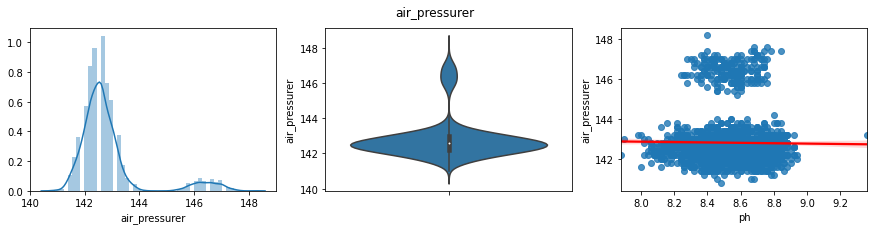

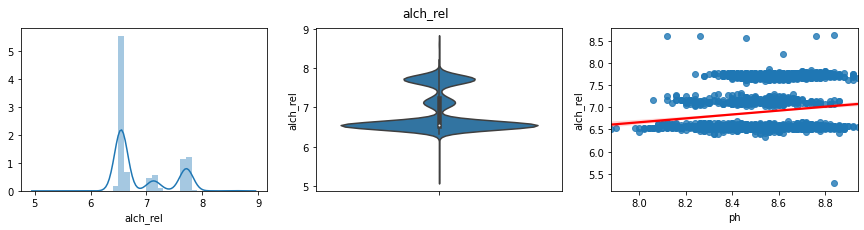

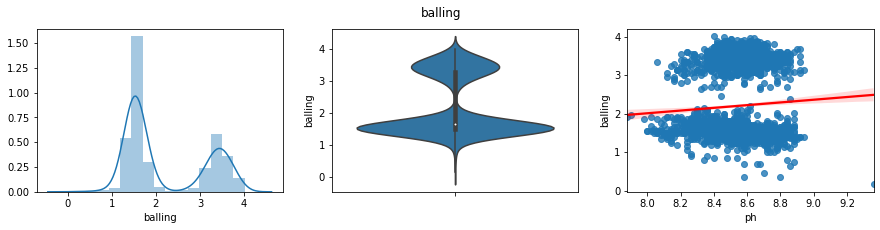

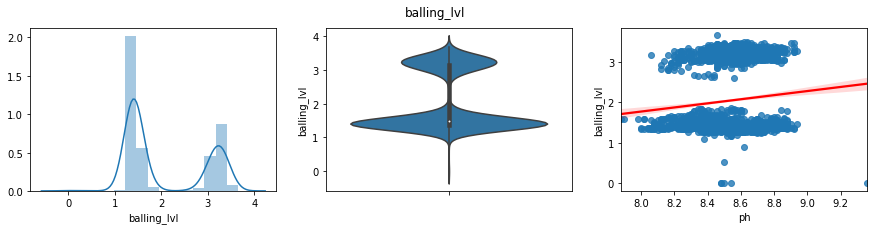

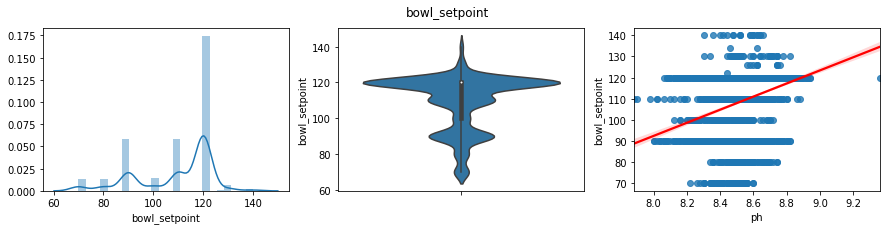

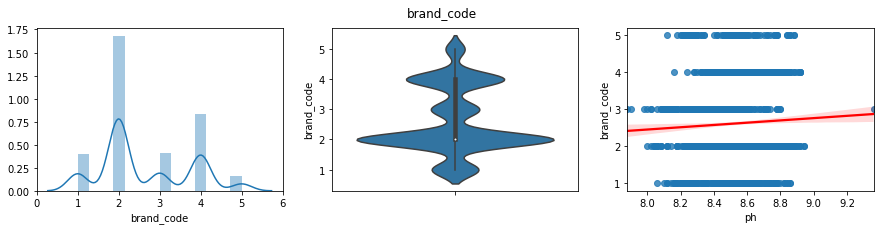

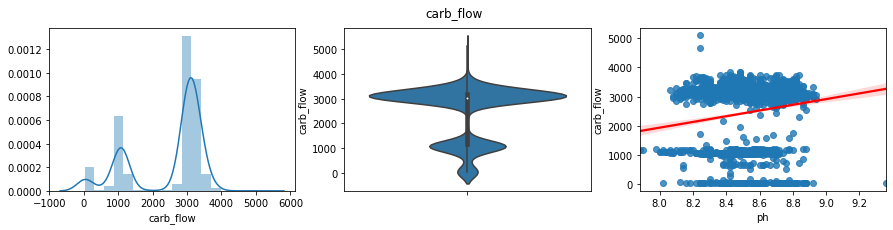

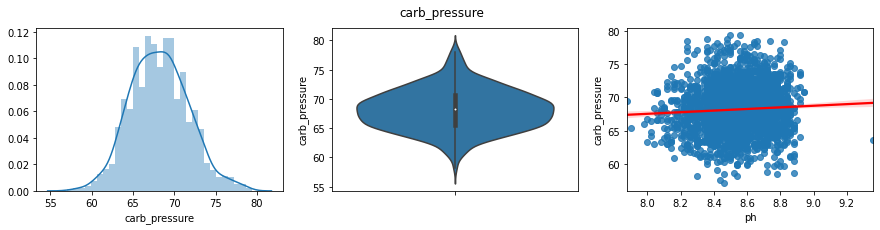

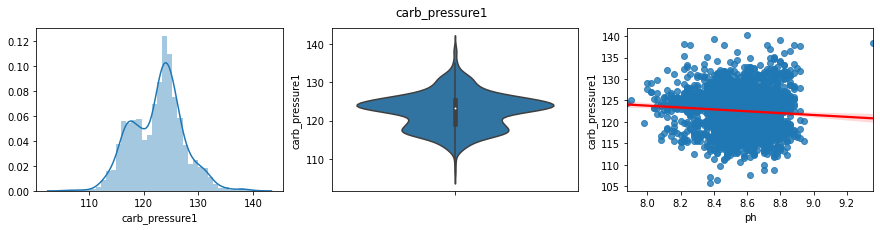

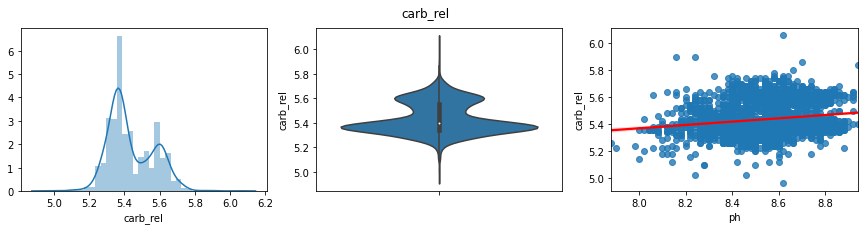

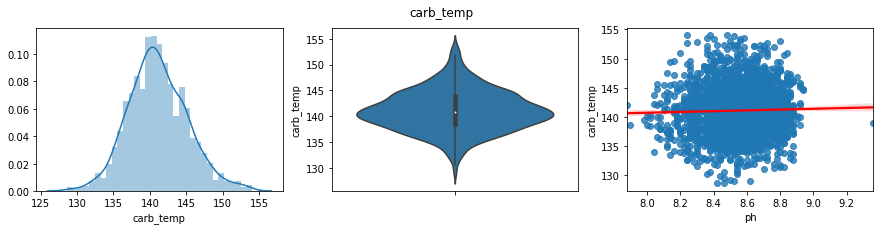

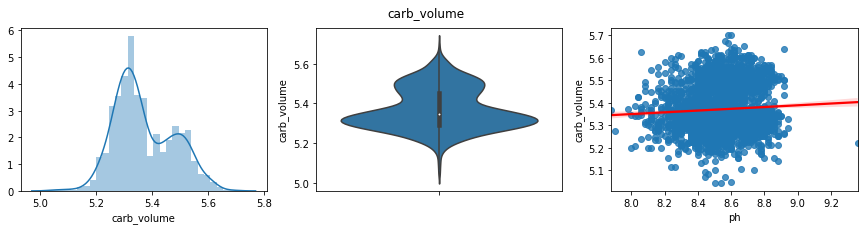

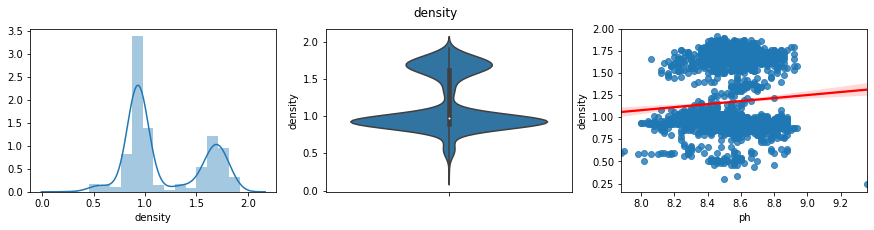

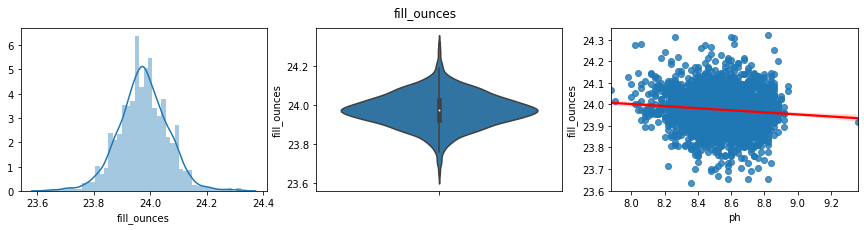

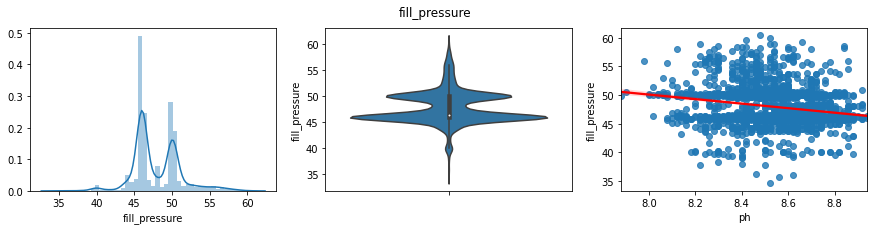

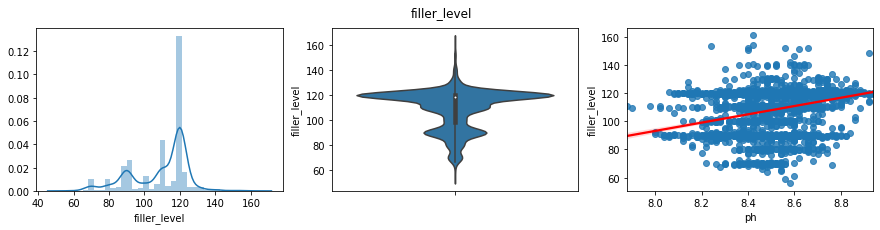

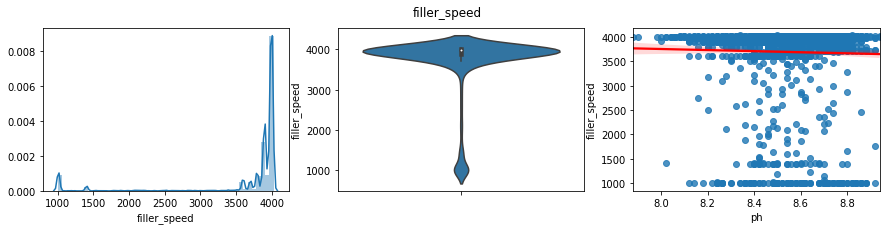

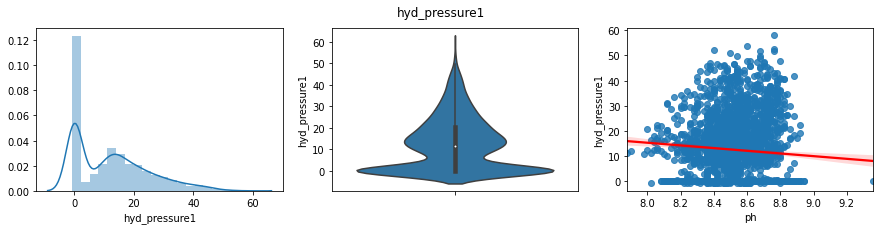

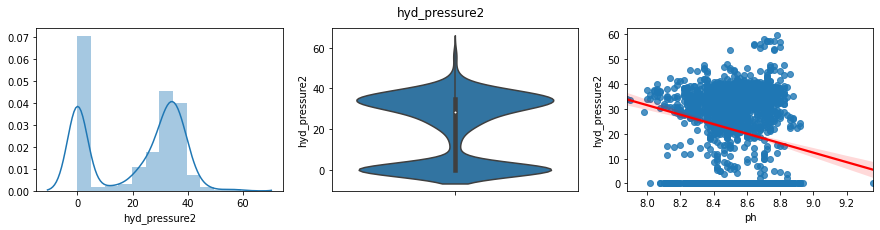

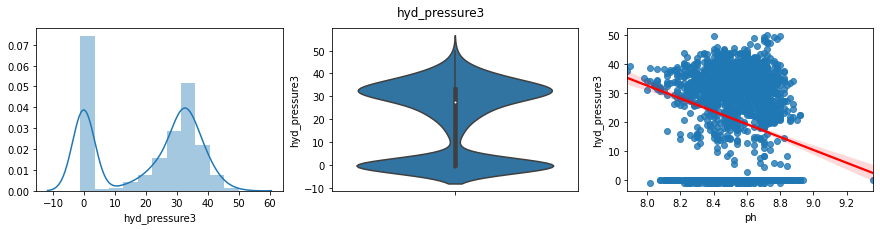

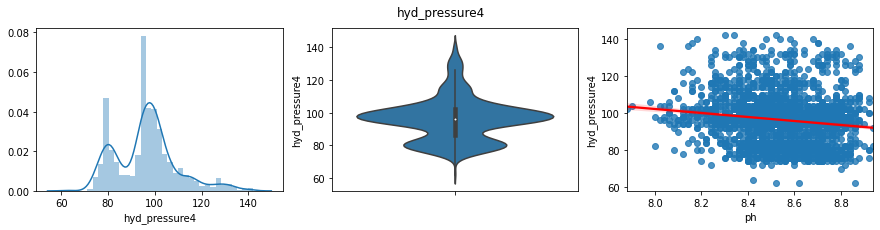

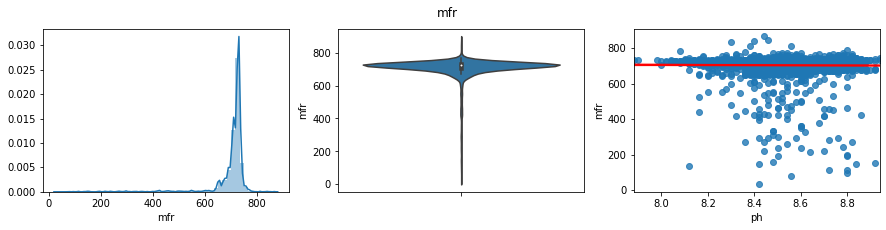

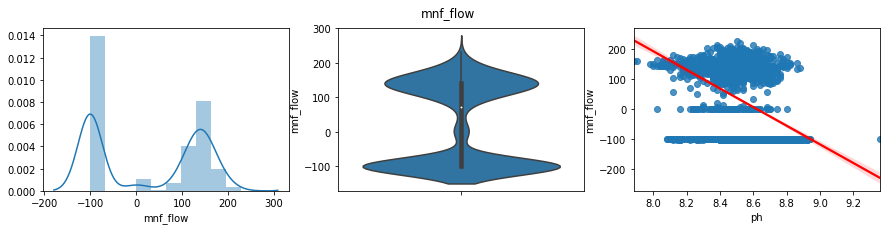

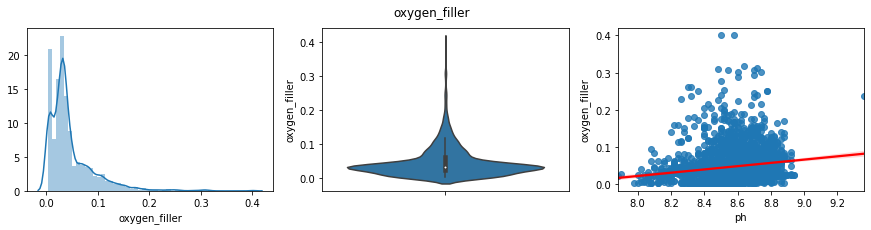

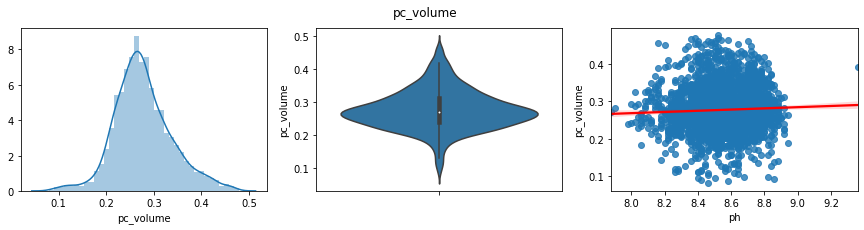

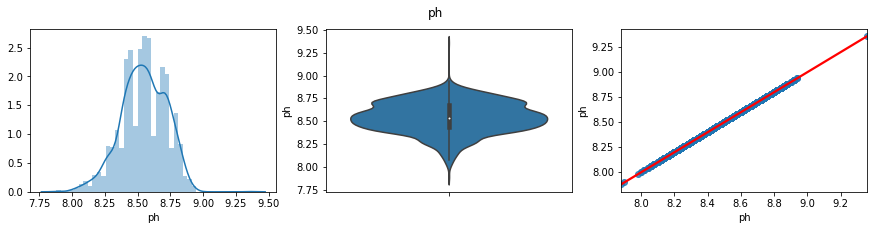

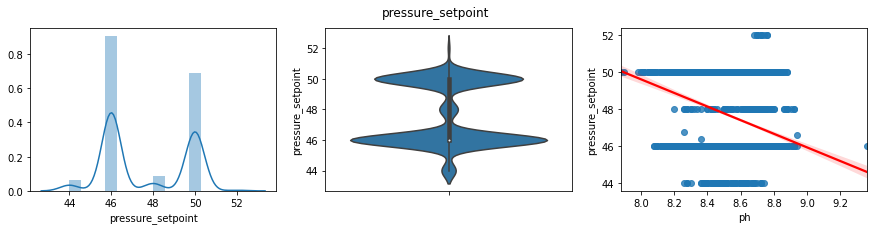

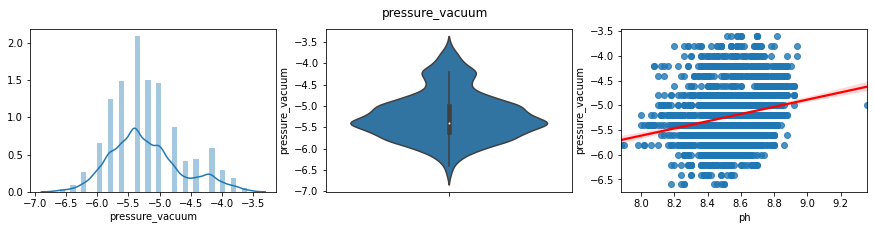

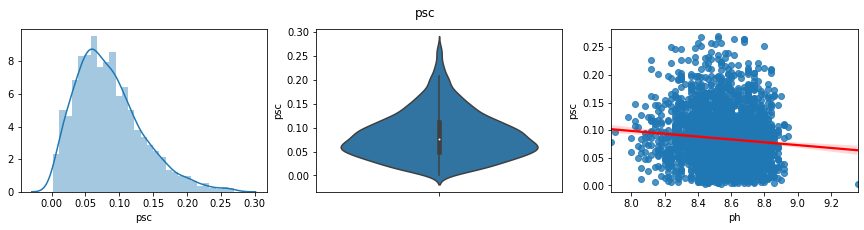

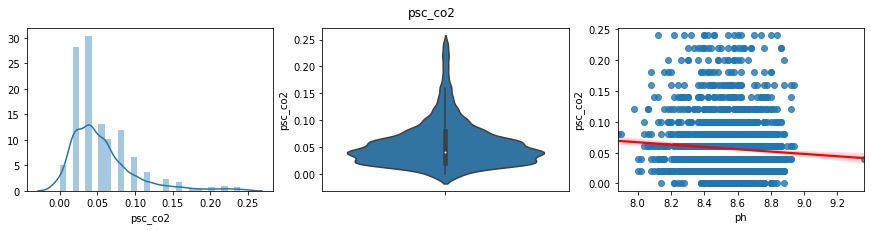

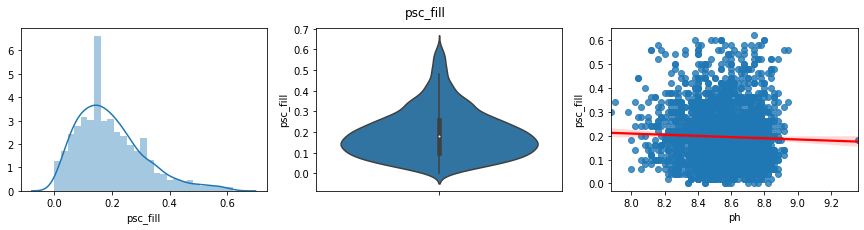

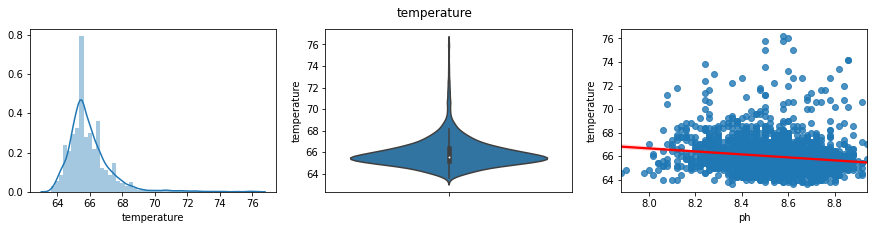

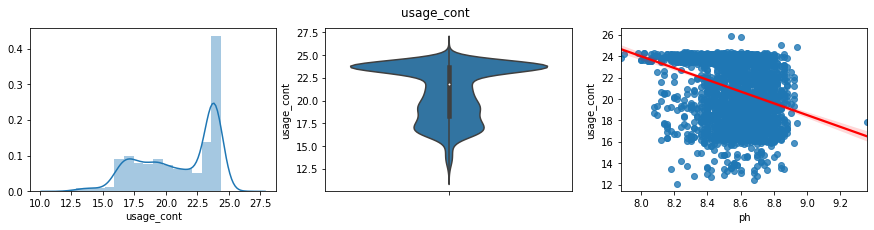

In [8]:
visuals(data)

### Run transformations

Based on the visual review of the charts, near normal and non normal lists were created.  Null values for normal
distributions will be addressed via filling with the features mean; while features with a non normal distribution will be addressed via filling with the features median.

In [9]:
#List of normally distributed and non normally distributed features
near_normal_list = ['fill_ounces','pc_volume','carb_pressure','carb_temp',
                        'psc_fill','carb_pressure1','temperature', 'mfr','pressure_vacuum', 'carb_rel']

non_normal_list = ['carb_volume','psc','psc_co2','mnf_flow','fill_pressure','hyd_pressure1','hyd_pressure2','hyd_pressure3',
                  'hyd_pressure4', 'filler_level','filler_speed','usage_cont','carb_flow','density','balling', 
                  'oxygen_filler','bowl_setpoint','pressure_setpoint','air_pressurer','alch_rel','balling_lvl']

In [10]:
data = transformations(data, near_normal_list, non_normal_list)

### Create train & test datasets

In [11]:
#Create train and test dataset
train, test = train_test_split(data,test_size=0.3) 

In [12]:
#Create X_train, y_train and X_test, y_test datasets
X_train = train.drop('ph', axis=1)
y_train = train['ph']

X_test = test.drop('ph', axis=1)
y_test = test['ph']

## Random Forest All Features Model
 

<B> Random Forest </B>
Selected Random Forest because sklearn offers the ability to use this algorithm to identify features in order of importance relative to the PH that we are trying to predict.  

<I> Helpful links:</I>  
[Towards Data Science: Feature Selection Using Random Forest](https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f)  
[Chris Albion: Feature Selection Using Random Forest](https://chrisalbon.com/code/machine_learning/trees_and_forests/feature_selection_using_random_forest/)

### Create and train

In [13]:
# Create a random forest regressor
rfall = RandomForestRegressor(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the regressor
rfall.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10000, n_jobs=-1, random_state=0)

### Feature importance

In [14]:
# Print the name and gini importance of each feature
rfall_gini_values_df = pd.DataFrame(columns=['feature','importance'])

for feature in zip(list(X_train.columns), rfall.feature_importances_):
    rfall_gini_values_df = rfall_gini_values_df.append({'feature': feature[0], 'importance': round(feature[1],2)},
                                                         ignore_index=True)

rfall_gini_values_df = rfall_gini_values_df.sort_values('importance', ascending=False)

rfall_gini_values_df.to_excel('data/' + 'all_features_ranked_by_gini_values.xlsx', index=False)

rfall_gini_values_df

,feature,importance
9,mnf_flow,0.23
30,carb_rel,0.06
29,alch_rel,0.06
25,oxygen_filler,0.05
18,temperature,0.05
31,balling_lvl,0.04
28,air_pressurer,0.04
24,pressure_vacuum,0.04
10,carb_pressure1,0.04
19,usage_cont,0.04


### Test

In [15]:
# Apply The Full Featured regressor To The Test Data
y_rfall = rfall.predict(X_test)

### Score

In [16]:
#MAPE for the initial model (32 features)
models_mape = round(mape(y_test, y_rfall),3)
print('MAPE for the all features random forest model is', models_mape, '%')

MAPE for the all features random forest model is 0.865 %


## Random Forest Best Model

In [17]:
#Create a set of the gini values rounded to two decimal places
thresholds_set = sorted(set(rfall_gini_values_df.importance.values))
thresholds_set = thresholds_set[:-1]
thresholds_set

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]

In [18]:
# Create a selector object that will use the random forest regressor to identify
# features that have an importance of more than 0.04
best_model_candidates_df = pd.DataFrame(columns=['threshold', 'features', 'mape'])

for g in thresholds_set:
    rfselector = SelectFromModel(rfall, threshold=g)
    
    # Train the selector
    rfselector.fit(X_train, y_train)
    
    # Transform the data to create a new dataset containing only the most important features
    # Note: We have to apply the transform to both the training X and test X data.
    X_important_train = rfselector.transform(X_train)
    X_important_test = rfselector.transform(X_test)
    
    # Create a new random forest regressor for the most important features
    rfbest = RandomForestRegressor(n_estimators=10000, random_state=0, n_jobs=-1)
    
    # Train the new regressor on the new dataset containing the most important features
    rfbest.fit(X_important_train, y_train)
    
    # Apply the important regressor To The Test Data
    y_rfbest = rfbest.predict(X_important_test)
    
    # Print the name of each feature from the sfm model
    features_list = []
    for feature_list_index in rfselector.get_support(indices=True):
        features_list.append(X_train.columns[feature_list_index])
    
    if len(features_list) == 0:
        features_list.append('no features')
        
    #Calculate MAPE
    models_mape = round(mape(y_test, y_rfbest),3)
    
    #Add to candidate models dataframe
    best_model_candidates_df = best_model_candidates_df.append({'threshold':g,
                                                                'features':features_list,
                                                                'mape':models_mape}, ignore_index=True)

In [19]:
#Sort the best_model_candidates with the best model first
best_model_candidates_df = best_model_candidates_df.sort_values('mape')

best_model_candidates_df.to_excel('data/' + 'best_model_candidates_output_ken.xlsx', index=False)

best_model_candidates_df

,threshold,features,mape
2,0.02,"[brand_code, pc_volume, mnf_flow, carb_pressur...",0.834
0,0.00,"[brand_code, carb_volume, fill_ounces, pc_volu...",0.865
1,0.01,"[brand_code, carb_volume, fill_ounces, pc_volu...",0.865
3,0.03,"[mnf_flow, carb_pressure1, temperature, usage_...",0.891
4,0.04,"[mnf_flow, temperature, oxygen_filler, air_pre...",0.981
5,0.05,"[mnf_flow, alch_rel, carb_rel]",1.249
6,0.06,"[mnf_flow, alch_rel, carb_rel]",1.249


## To Predict Data

### Load and clean

In [20]:
#Load the final predictions data and prepare X data to run the model
final_predictions_df = pd.read_excel('.\data\StudentEvaluation- TO PREDICT.xlsx')

final_predictions_df_clean = clean_data(final_predictions_df, 'final')

Data metrics prior to cleanup...
Brand code is null: 8
PH is null count: 267
Rows with all null values count: 0
Rows with at least one null value count: 267


### Run Transformations

In [21]:
final_predictions_df_clean = transformations(final_predictions_df_clean, near_normal_list, non_normal_list)

X_final_predictions = final_predictions_df_clean.drop('ph', axis=1)

In [22]:
#Need to transform to only have best model features
X_important_final_predictions = rfselector.transform(X_final_predictions)

### Make predictions

In [23]:
y_final_predictions = rfbest.predict(X_important_final_predictions)

### Output to spreadsheet

In [24]:
final_predictions_df['ph'] = y_final_predictions

final_predictions_df.to_excel('data/' + 'random_forest_predictions_ken.xlsx', index=False)